### Imports

In [4]:
from jaxflows.flows import NeuralSplineFlow
from jaxflows.train_utils import train_flow

import matplotlib.pyplot as plt
from sklearn import preprocessing
import jax.numpy as jnp
import numpy as onp
from jax import random
from rnpe.denoise import horseshoe_denoiser_model
from numpyro.infer.hmc import NUTS
from numpyro.infer.mcmc import MCMC


### Load dataset

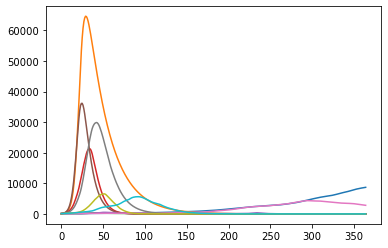

In [9]:
simulations = jnp.load("data/sirsde/simulations.npz")
theta = simulations["theta"]
x = simulations["x"]
x = jnp.array(x)
plt.plot(jnp.transpose(x[:10]))
plt.show()

### Create misspecification

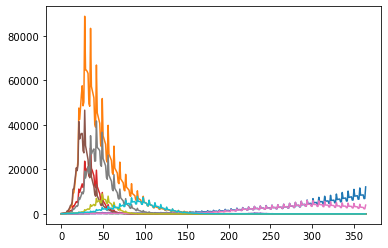

In [10]:
def get_day_idx(days: list):
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    weekdays = {day: i for i, day in enumerate(weekdays)}
    idxs = []
    for day in days:
        idxs += list(range(weekdays[day], 365, 7))
    return sorted(idxs)

def misspecify(x, multiplier=0.8):
    x = onp.array(x)
    x = x.copy()
    days = ["saturday", "sunday", "monday"]
    sat_idx, sun_idx, mon_idx = [get_day_idx([d]) for d in days]
    mon_idx = mon_idx[1:]
    sat_new = x[:, sat_idx] * multiplier
    sun_new = x[:, sun_idx] * multiplier
    missed_cases = (x[:, sat_idx] - sat_new) + (x[:, sun_idx] - sun_new)
    mon_new = x[:, mon_idx] + missed_cases

    for idx, new in zip([sat_idx, sun_idx, mon_idx], [sat_new, sun_new, mon_new]):
        x[:, idx] = new
    return jnp.array(x)

x_misspecified = misspecify(x)
plt.plot(jnp.transpose(x_misspecified[:10]))
plt.show()

### Calculate summary statistics

### Train flow on dataset

In [3]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
key, subkey = random.split(key)
flow = NeuralSplineFlow(flow_key, target_dim=x.shape[1])
flow, losses = train_flow(train_key, flow, x)

 66%|██████▌   | 33/50 [00:30<00:15,  1.07it/s, train=1.19, val=1.22]

Max patience reached.


### Denoise with MCMC

In [19]:
y_obs = jnp.array([1.7, 1.5])
kernel = NUTS(horseshoe_denoiser_model)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=10000)
mcmc.run(random.PRNGKey(42), y_obs, flow.bijection.inverse)
mcmc.print_summary()

sample: 100%|██████████| 13000/13000 [00:33<00:00, 386.17it/s, 47 steps of size 2.50e-02. acc. prob=0.55]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]    423.28   1969.69      6.32      0.03   1033.39     73.22      1.00
lambdas[1]    679.61   7337.38      5.04      0.00    530.47    429.68      1.00
    tau[0]      0.11      0.44      0.01      0.00      0.22   1013.18      1.00
      z[0]      0.70      0.90      1.02     -0.35      1.88     13.43      1.00
      z[1]      0.33      0.51      0.44     -0.38      1.06     82.23      1.00

Number of divergences: 3128


### Plot samples

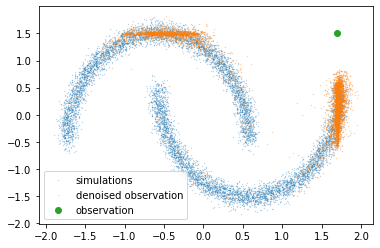

In [42]:
mcmc_samples = mcmc.get_samples()["x"]

plt.scatter(
    x[:, 0],
    x[:, 1],
    alpha=0.4,
    s=0.1, label = "simulations"
)

plt.scatter(
    mcmc_samples[:, 0],
    mcmc_samples[:, 1],
    s=0.1,
    label="denoised observation",
    alpha=0.5
)

plt.scatter(
    x = y_obs[0],
    y = y_obs[1],
    label="observation",
)

plt.legend(loc="lower left")